In [15]:
# Basic math functions
import math
from math import exp, sqrt, floor

# For more complex math and data operations
import pandas as pd
import numpy as np
import scipy.linalg as la

# For plotting and mapping
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import plotly.express as px
import plotly.graph_objects as go

# For displaying progress bars on code blocks
# some functions take a long time to run, so this is helpful for sanity
from tqdm import tqdm

# For dealing with dates and times of seismic events
from dateutil import parser
from datetime import datetime, timedelta

# For requesting data from within python
import requests

# obspy is a package for working with mseed seismic time series files
# For finding p wave and s wave arrivals from time series
import obspy
from obspy.signal.trigger import ar_pick

# For mapping
import cartopy
import cartopy.crs as ccrs

I obtained seismic event data from 2017-2024 from the New Mexico Tech Seismological Observatory. For now, I plan to use data from the 13 events with the largest magnitude.

In [2]:
events = pd.read_csv('NM_SeismicEvents.csv')
events = events.sort_values(by='Magnitude', ascending=False)
events[0:13]

,Date+Time(UTC),Lat(84),Long(84),Depth(km),Magnitude,RMS,STD(km),NoStations
268,2024-02-23 09:47:07.0,32.626965,-104.402706,8.60,4.49,0.38,1.70,28
808,2023-05-18 01:04:20.0,35.321045,-107.435303,5.00,4.22,0.53,4.03,12
385,2023-12-18 23:55:11.0,36.866455,-104.849853,5.00,4.06,0.54,2.45,17
1980,2021-07-19 11:23:25.8,32.090000,-103.704000,5.00,4.03,0.48,1.80,13
661,2023-08-06 10:27:59.0,36.926880,-104.877319,5.00,3.97,0.59,2.70,15
245,2024-02-24 23:50:11.0,32.643862,-104.399942,2.62,3.93,0.41,1.49,27
865,2023-04-30 05:20:22.0,34.304810,-106.862183,5.00,3.78,0.53,4.10,16
904,2023-04-18 20:31:36.0,32.366638,-104.475403,5.00,3.65,0.37,1.58,31
837,2023-05-05 15:09:30.0,36.910400,-104.849853,5.00,3.65,0.44,2.74,10
854,2023-05-02 15:19:36.0,36.824341,-104.913940,5.00,3.62,0.42,5.11,6


Even though I'm only focusing on those events for now, I'll plot out all of them (and then just those thirteen) just to see what data I'm working with!

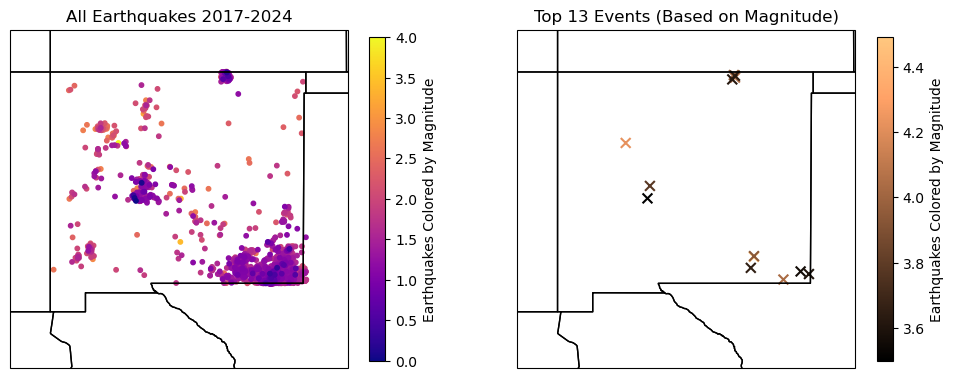

In [3]:
lat = events['Lat(84)']
lon = events['Long(84)']
mag = events['Magnitude']

lat_15 = events[0:13]['Lat(84)']
lon_15 = events[0:13]['Long(84)']
mag_15 = events[0:13]['Magnitude']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax1.coastlines()
ax1.add_feature(cartopy.feature.STATES, linestyle='-')
ax1.set_extent([-110,-102,30,38], crs=ccrs.PlateCarree())
data = ax1.scatter(lon, lat, 10, mag, cmap='plasma', vmin=0,vmax=4, transform = ccrs.PlateCarree())
colorbar = plt.colorbar(data, shrink=0.7)
colorbar.set_label('Earthquakes Colored by Magnitude')
ax1.set_title("All Earthquakes 2017-2024")

ax2.coastlines()
ax2.add_feature(cartopy.feature.STATES, linestyle='-')
ax2.set_extent([-110,-102,30,38], crs=ccrs.PlateCarree())
data = ax2.scatter(lon_15, lat_15, 50, mag_15, 'x', cmap='copper', transform = ccrs.PlateCarree())
colorbar = plt.colorbar(data, shrink=0.7)
colorbar.set_label('Earthquakes Colored by Magnitude')
ax2.set_title("Top 13 Events (Based on Magnitude)")

plt.show()

To get information about those seismic events, I will need to pull data from seismic stations. First, I want to see what seismic stations are available to pull data from, so I'll look at some metadata on the stations. For all of the following data requests, I will use the online database from the FDSN (International Federation of Digital Seismograph Networks) via online web serives from SAGE (Seismological Facility for the Advancement of Geoscience), which supports url requests from within coding languages like Python.

In [4]:
# Seeing which stations are within my geographic region of interest
url = 'http://service.iris.edu/fdsnws/station/1/query?'
params={
    'minlatitude': 30,
    'maxlatitude': 38,
    'minlongitude': -110,
    'maxlongitude': -102
}
response = requests.get(url, params=params)

Response comes back as a stationXML format, which is different from XML. Schema info is here: https://docs.fdsn.org/projects/stationxml/en/latest/overview.html#. I used the schema info to parse the stationXML file into a pandas dataframe.

In [5]:
response_str =response.text.split('\n')

network_names = []
stations = []
lats = []
lons = []
elevs = []

for line in response_str:
    trimmed_line = line.lstrip()
    
    if trimmed_line.startswith("<Network"):
        
        # Get Network Name
        start_i = trimmed_line.find("code")
        end_i = trimmed_line.find("startDate")
        network_name = trimmed_line[start_i+6:end_i-2]
        # Don't append network
        # will append network each time a station is appended
    
    if trimmed_line.startswith("<Station"):
        
        # Get Station Name
        start_i = trimmed_line.find("code")
        end_i = trimmed_line.find("startDate")
        station_name = trimmed_line[start_i+6:end_i-2]
        stations.append(station_name)
        
        # Append another network b/c multiple stations per network
        network_names.append(network_name)
    
    if trimmed_line.startswith("<Latitude"):
        
        # Get Latitude
        start_i = trimmed_line.find(">")
        end_i = trimmed_line.find("</")
        lat = trimmed_line[start_i+1:end_i]
        lats.append(float(lat))
        
        
    if trimmed_line.startswith("<Longitude"):
        
        # Get Longitude
        start_i = trimmed_line.find(">")
        end_i = trimmed_line.find("</")
        lon = trimmed_line[start_i+1:end_i]
        lons.append(float(lon))
        
    if trimmed_line.startswith("<Elevation"):
        
        # Get Elevation
        start_i = trimmed_line.find(">")
        end_i = trimmed_line.find("</")
        elev = trimmed_line[start_i+1:end_i]
        elevs.append(float(elev))

In [6]:
# Make a dataframe
station_metadata = {
    'Network': network_names,
    'Station': stations,
    'Latitude': lats,
    'Longitude': lons,
    'Elevation': elevs
}
df = pd.DataFrame(station_metadata)

# Save the dataframe to a csv
df.to_csv('station_metadata.csv',index=False)

In [11]:
df.head()

,Network,Station,Latitude,Longitude,Elevation
0,1A,WP01,33.840500,-103.867302,1362.0
1,1A,WP02,32.591000,-104.691704,1276.0
2,1A,WP03,32.491699,-104.515503,1272.0
3,1A,WP04,32.355202,-103.398499,1055.0
4,1A,WP05,32.264099,-103.879097,1043.0


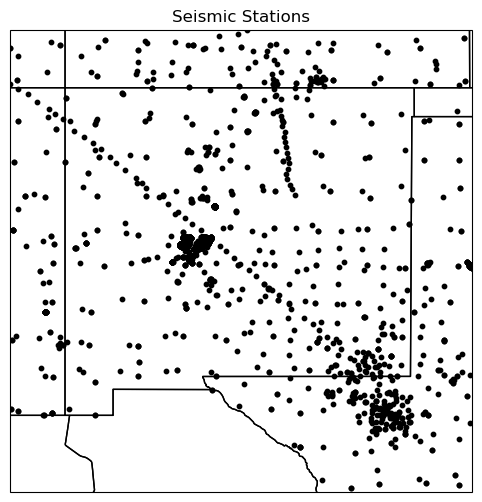

In [7]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.STATES, linestyle='-')
ax.set_extent([-110,-102,30,38], crs=ccrs.PlateCarree())

categories = df['Network']

ax.scatter(df['Longitude'], df['Latitude'], s=10, c='k',marker='o')

plt.title("Seismic Stations")
plt.show()

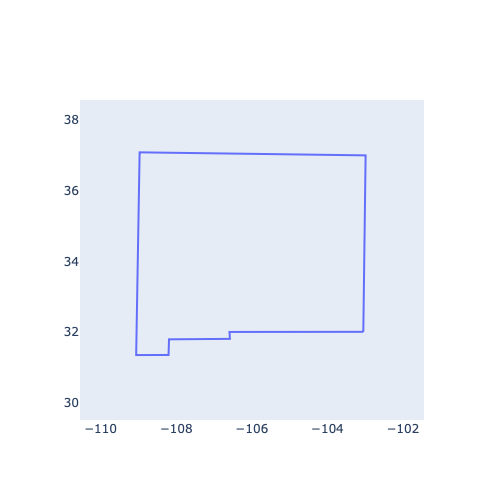

In [25]:
# Interactive Version

fig = px.scatter(df,x='Longitude',y='Latitude',
                hover_data=['Network','Station'])

# Add New Mexico to the Image
nm_lon = [-103.054811, -102.99401944, -108.9729388, -109.064133, -108.2076611, -108.19539722, -106.5839166, -106.595477, -103.054811]
nm_lat = [31.996511, 36.9873944, 37.073475, 31.33909722, 31.3416944, 31.78363055, 31.79769722, 31.992922, 31.996511]
fig2 = px.line(x=nm_lon, y=nm_lat)

fig_combined = go.Figure(data=fig.data + fig2.data)
fig_combined.update_xaxes(showgrid=False)
fig_combined.update_yaxes(showgrid=False)
fig_combined.update_layout(width=500,height=500)

fig_combined.show()